In [1]:
import numpy as np
import pandas as pd
import os
import soundfile as sf
from matplotlib import pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support


data_path = os.path.dirname(os.getcwd())


In [2]:
a = data_path+'\data\ASVspoof2019_LA_protocols\ASVspoof2019.LA.cm.train.trn.txt'
LA_label_train = pd.read_csv(a,sep=' ')
LA_label_train = LA_label_train.drop(['-'], axis=1)

a = data_path+'\data\ASVspoof2019_LA_protocols\ASVspoof2019.LA.cm.dev.trl.txt'
LA_label_dev = pd.read_csv(a,sep=' ')
LA_label_dev = LA_label_dev.drop(['-'], axis=1)

In [3]:
LA_label_train.head()

,SPEAKER_ID,AUDIO_FILE_NAME,SYSTEM_ID,KEY
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [4]:
# feature extractation
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

path = data_path+'\\data\\ASVspoof2019_LA_train\\flac'

features = []
labels = []

for i in range(0,LA_label_train.shape[0]):
    y, sr = sf.read(path+'\\'+LA_label_train['AUDIO_FILE_NAME'][i]+'.flac')     
    feat = librosa.feature.mfcc(y=y, sr=sr)
    features.append(feat)
    a = np.tile(LA_label_train['KEY'][i], feat.shape[1])
    labels.append(a) 
    print(i,end=' ')
    if(i%500==0):
        clear_output()
    
tr_features = np.hstack((features)).T
tr_labels = np.hstack(labels)
LABELS = np.unique(tr_labels)
label_idx = {label: i for i, label in enumerate(LABELS)}
vfunc = np.vectorize(lambda x: label_idx[x])
tr_labels=vfunc(tr_labels)
tr_labels = one_hot_encode(tr_labels)

np.save('../data/features/data_x',tr_features)
np.save('../data/features/data_y',tr_labels)

clear_output()

In [17]:
tr_features.shape

(2729785, 20)

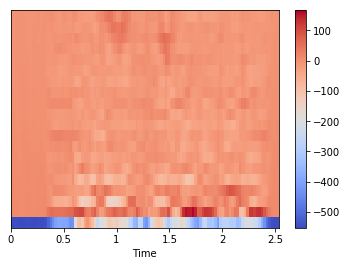

In [103]:
librosa.display.specshow(features[0], x_axis='time')
plt.colorbar()

In [ ]:
# for rnn extract MFCC features and save it to files
bands = 20
frames = 41
window_size = 512 * (frames - 1)

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

features = []
labels = []

for fn in range(0,100):
    print(str(fn), end=' ')
    y, sr = sf.read(path+'\\'+LA_label_train['AUDIO_FILE_NAME'][i]+'.flac')     
    for (start,end) in windows(y,window_size):
        start = int(start)
        end = int(end)
        if(len(y[start:end]) == window_size):
            signal = y[start:end]
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = bands).T.flatten()[:, np.newaxis].T
            features.append(mfcc)
            labels.append(LA_label_train['KEY'][i]) 
            
features = np.asarray(features).reshape(len(features),frames,bands)

# save features to file
tr_features = np.array(features)
tr_labels = np.array(labels)
LABELS = np.unique(tr_labels)
label_idx = {label: i for i, label in enumerate(LABELS)}
vfunc = np.vectorize(lambda x: label_idx[x])
tr_labels=vfunc(tr_labels)
tr_labels = one_hot_encode(tr_labels)

np.save('../data/features/data_x',tr_features)
np.save('../data/features/data_y',tr_labels)

clear_output()

# traning

In [23]:
# split train validation set
X = np.load('../data/features/data_x.npy')
Y = np.load('../data/features/data_y.npy')

tr_features, tr_labels = shuffle(X, Y, random_state=0)
a = tr_features.shape[0]

tr_features = tr_features[:int(a*0.3)]
tr_labels = tr_labels[:int(a*0.3)]


train_features, test_features, train_labels, test_labels = train_test_split(tr_features,
                                                                            tr_labels, 
                                                                            test_size = 0.3, 
                                                                            random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

Train shape:  (573254, 20)
Test shape:  (245681, 20)


In [24]:
training_epochs = 50
n_dim = tr_features.shape[1]
n_classes = 2
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [25]:
#
tf.reset_default_graph()

#
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)



#
cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#
init = tf.global_variables_initializer()

In [20]:
# tensorboard
session = tf.Session()
#to create the graph summary
writer = tf.summary.FileWriter('logdir', session.graph)

In [26]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as session:
    session.run(init)
    
    for epoch in range(training_epochs):            
        _,cost = session.run([optimizer,cost_function],feed_dict={X:train_features,Y:train_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = session.run(tf.argmax(y_,1),feed_dict={X: test_features})
    y_true = session.run(tf.argmax(test_labels,1))
    print("Test accuracy: ",
          round(session.run(accuracy, feed_dict={X: test_features,Y: test_labels}),3))

ResourceExhaustedError: OOM when allocating tensor with shape[573254,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients_1/MatMul_2_grad/MatMul (defined at <ipython-input-25-4b0d8090c374>:26)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients_1/add_2_grad/Reshape, Variable_4/read, ^gradients_1/add_2_grad/tuple/group_deps)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'gradients_1/MatMul_2_grad/MatMul', defined at:
  File "C:\Users\EspVicon\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\EspVicon\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\EspVicon\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\EspVicon\Anaconda3\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\EspVicon\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-4b0d8090c374>", line 26, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_function)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 400, in minimize
    grad_loss=grad_loss)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 519, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 1130, in _MatMulGrad
    grad_a = gen_math_ops.mat_mul(grad, b, transpose_b=True)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'MatMul_2', defined at:
  File "C:\Users\EspVicon\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 25 identical lines from previous traceback]
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-4b0d8090c374>", line 19, in <module>
    y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2057, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\EspVicon\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[573254,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients_1/MatMul_2_grad/MatMul (defined at <ipython-input-25-4b0d8090c374>:26)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients_1/add_2_grad/Reshape, Variable_4/read, ^gradients_1/add_2_grad/tuple/group_deps)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
#plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print ("F-Score:", round(f,3))

In [17]:
cost_history.shape

(51,)